In [1]:
# Prereq libraries
import numpy as np
import pandas as pb

# Possibly useful TensorFlow and Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM
import tensorflow as tf

# Dataset parameters
TRAINING_SPLIT = 0.2
FILE = 'min75_max5k_as_ids.csv'

# Read in dataset from csv files
dataset = pb.read_csv(FILE)

In [2]:
from functs import npFloatArray, load_data

# load features and labels based on those present in the CSV files
features = np.array(dataset.copy())

# Load Data
X_train, X_test, y_train, y_test = load_data(dataset, 
                                             TRAINING_SPLIT)

# Double check X_train's shape
print("X_train's Shape: " + str(X_train.shape[0]))

# Set up dataset for model fitting
num_rows, num_cols = X_train.shape
X_train = np.reshape(X_train, (X_train.shape[0],
                               1,
                               X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],
                             1,
                             X_test.shape[1]))

Max Y Index: 130
Max X Index: 3276
X_train's Shape: 14270


Epoch 1/200
446/446 [==============================] - 14s 26ms/step - loss: 0.0301 - accuracy: 0.2167 - precision: 0.7822 - root_mean_squared_error: 0.1735 - val_loss: 0.0291 - val_accuracy: 0.2710 - val_precision: 0.8062 - val_root_mean_squared_error: 0.1707
Epoch 2/200
446/446 [==============================] - 11s 25ms/step - loss: 0.0276 - accuracy: 0.3007 - precision: 0.8635 - root_mean_squared_error: 0.1663 - val_loss: 0.0287 - val_accuracy: 0.2478 - val_precision: 0.8184 - val_root_mean_squared_error: 0.1695
Epoch 3/200
446/446 [==============================] - 11s 25ms/step - loss: 0.0265 - accuracy: 0.3493 - precision: 0.9229 - root_mean_squared_error: 0.1628 - val_loss: 0.0286 - val_accuracy: 0.2803 - val_precision: 0.8055 - val_root_mean_squared_error: 0.1690
Epoch 4/200
446/446 [==============================] - 11s 25ms/step - loss: 0.0255 - accuracy: 0.3856 - precision: 0.9632 - root_mean_squared_error: 0.1598 - val_loss: 0.0286 - val_accuracy: 0.2654 - val_precision: 0

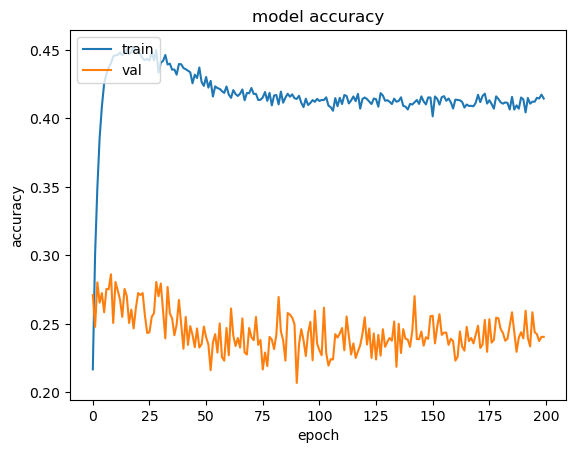

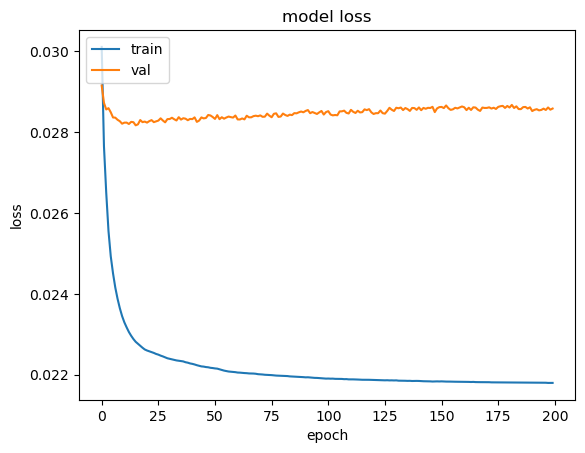

In [3]:
from matplotlib import pyplot as plt
from functs import myPrint
from keras.callbacks import CSVLogger

# RNN model implementation using Keras Library
# Inspired by https://www.youtube.com/watch?v=BSpXCRTOLJA

# Create sequential model object
model = Sequential()

# First input layer using LSTM with window size 64, train_x shape, & RelU activation [131 nodes]
model.add(LSTM(num_cols, input_shape = (X_train.shape[1:]),
               activation = 'relu', 
               return_sequences = True))
model.add(Dropout(0.2))

# First hidden layer using LSTM with RelU activation [512 nodes]
model.add(LSTM(int(512), 
               activation = 'relu'))
model.add(Dropout(0.2))

# Final output layer using softmax activation [131 nodes]
model.add(Dense(int(y_train.shape[1:][0]), 
                activation = 'softmax'))

# optimizer used for compilation, 'Adam' refers to gradient descent method that "adapts" using first and second order moments
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3, 
                               decay = 1e-5)

# Final compilation
# Metrics used: accuracy, precision, RMSE
model.compile(loss = 'mean_squared_error', 
              optimizer = opt, 
              metrics = ['accuracy', 
                         tf.keras.metrics.Precision(), 
                         tf.keras.metrics.RootMeanSquaredError()])

# Model Fitting process, this is the last step
csv_logger = CSVLogger('log.txt', 
                       append = True, 
                       separator = ';')
history = model.fit(X_train, 
                    y_train, 
                    epochs = 200, 
                    validation_data = (X_test, 
                                       y_test), 
                    callbacks = [csv_logger])

# Plot Measurment Results
# From: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig1 = plt.gcf()
plt.show()
fig1.savefig('Accuracy_Over_Time.png')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig2 = plt.gcf()
plt.show()
fig2.savefig('Loss_Over_Time.png')

# viewable summary
summary = model.summary(print_fn = myPrint)
